In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Heat-Transfer Equation

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import time
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())



cuda


In [3]:
# Reading data
data = pd.read_csv('/content/gdrive/MyDrive/project_one/2D_plate_Heattransfer/solution.csv')


In [4]:
x = data.loc[:, ['x', 'y']].to_numpy()
T = data['Temperature'].to_numpy()
print(T)
T_max = T.max()
T_min = T.min()
T_mean = T.mean()
T = ((T-T_min)/(T_max-T_min))
# T = ((T-T_min)/(T_max-T_min))*2 - 1

T = T.flatten('F')[:,None] #Fortran style (Column Major)
print(x.shape)
print(T.shape)

from sklearn.model_selection import train_test_split
x_train_nu, x_train_nf, T_train_nu, T_train_nf = train_test_split(x, T, test_size=0.85)


[400.   399.59 399.24 ... 390.22 394.12 400.  ]
(1089, 2)
(1089, 1)


In [5]:
'Convert to tensor and send to GPU'
print(x_train_nf.shape)
print(x_train_nu.shape)
print(T_train_nu.shape)
x_train_nf = torch.from_numpy(x_train_nf).float().to(device)
x_train_nu = torch.from_numpy(x_train_nu).float().to(device)
T_train_nu = torch.from_numpy(T_train_nu).float().to(device)
x_test = torch.from_numpy(x).float().to(device)
T_true = torch.from_numpy(T).float().to(device)
f_hat = torch.zeros(x_train_nf.shape[0],1).to(device)

(926, 2)
(163, 2)
(163, 1)


In [6]:
k = 45
lambda_u = 1
# lambda_f = 1e-10
lambda_f = 0.5e-10

class FCN(nn.Module):

    def __init__(self,layers):
        super().__init__() #call __init__ from parent class

        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')

        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0

        'Xavier Normal Initialization'
        for i in range(len(layers)-1):

            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)

            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):

        # if torch.is_tensor(x) != True:
        #     x = torch.from_numpy(x)

        # u_b = torch.from_numpy(ub).float().to(device)
        # l_b = torch.from_numpy(lb).float().to(device)

        # #preprocessing input
        # x = (x - l_b)/(u_b - l_b) #feature scaling

        #convert to float
        a = x.float()

        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        a = self.linears[-1](a)

        return a

    def loss_space(self,x,y):

        loss_T = self.loss_function(self.forward(x), y)

        return loss_T

    def loss_PDE(self, x_train_nf):

        g = x_train_nf.clone()

        g.requires_grad = True

        T_nfp = self.forward(g)

        T_nfp_x_y = autograd.grad(T_nfp,g,torch.ones([x_train_nf.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        T_nfp_xx_yy = autograd.grad(T_nfp_x_y,g,torch.ones(x_train_nf.shape).to(device), create_graph=True)[0]

        T_nfp_xx = T_nfp_xx_yy[:,[0]]
        T_nfp_yy = T_nfp_xx_yy[:,[1]]

        #f = u_t + (self.forward(g))*(u_x) - (nu)*u_xx
        f = k*(T_nfp_xx + T_nfp_yy)
        loss_f = self.loss_function(f,f_hat)

        return loss_f

    def loss(self,x,y,x_train_nf):

        loss_u = self.loss_space(x,y)
        loss_f = self.loss_PDE(x_train_nf)
        # print('loss_u')
        # print(loss_u.mean())
        # print('loss_f')
        # print(loss_f.mean())

        # loss_val = (lambda_u * loss_u) + loss_f
        # loss_val = loss_u + loss_f*lambda_f

        # loss_val = (lambda_u * loss_u ) + (loss_f * lambda_f * loss_f.mean())

        loss_val = (lambda_u * loss_u ) + (loss_f * lambda_f)

        return loss_val

    'callable for optimizer'
    def closure(self):

        ############## optimizer.zero_grad()

        loss = self.loss(x_train_nu, T_train_nu, x_train_nf)

        loss.backward()

        self.iter += 1

        if self.iter % 500 == 0:

            error_vec, _ = PINN.test()

            print(loss,error_vec)

        return loss

    'test neural network'
    def test(self):

        u_pred = self.forward(x_test)
        # print('u_pred')
        # print(u_pred)
        # print('T_true')
        # print(T_true)

        error_vec = torch.linalg.norm((T_true-u_pred),2)/torch.linalg.norm(T_true,2)        # Relative L2 Norm of the error (Vector)

        u_pred = u_pred.cpu().detach().numpy()

        u_pred = np.reshape(u_pred,(33, 33),order='F')

        return error_vec, u_pred

In [7]:
# Train the model
layers = np.array([2,20,20,20,20,20,20,20,1]) #7 hidden layers (20)
PINN = FCN(layers)

PINN.to(device)

# 'Neural Network Summary'
# print(PINN)

# params = list(PINN.parameters())

'''Optimization'''

'L-BFGS Optimizer'
# optimizer = torch.optim.LBFGS(PINN.parameters(), 1e-2,
#                               max_iter = 100,
#                               max_eval = None,
#                               tolerance_grad = 1e-10,
#                               tolerance_change = 1e-10,
#                               history_size = 100,
#                               line_search_fn = 'strong_wolfe')

# optimizer = torch.optim.LBFGS(PINN.parameters(), 1e-2,
#                               max_iter = 1000,
#                               max_eval = None,
#                               )

############################################################################
############################################################################


def init_normal(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)

# use the modules apply function to recursively apply the initialization
PINN.apply(init_normal)

optimizer = optim.Adam(PINN.parameters(), lr=2.5e-4, betas = (0.9,0.99),eps = 10**-15)

for epoch in range(10000):
  if epoch % 500 == 0:
    lambda_f = lambda_f * 1.1     # this
  PINN.zero_grad()
  loss = PINN.closure()
  optimizer.step()

############################################################################
############################################################################



start_time = time.time()

optimizer.step(PINN.closure)


elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))


''' Model Accuracy '''
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.0016, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0528, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0226, device='cuda:0', grad_fn=<DivBackward0>)
tensor(7.1309e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)
tensor(3.8844e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.7803e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.4147e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.5787e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.2547e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>)
tensor(1.8436e-05, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0074, devic

[[400.03177 400.10992 400.1812  ... 400.13162 400.02438 399.81216]
 [399.5905  399.6672  399.72324 ... 396.5962  396.17242 395.67883]
 [399.2544  399.3348  399.37677 ... 393.55667 392.75668 391.88843]
 ...
 [399.2644  399.3089  399.3443  ... 393.92844 392.51373 390.75146]
 [399.5606  399.6091  399.6491  ... 396.90656 395.78537 394.28577]
 [399.86298 399.91522 399.95947 ... 399.89124 399.10486 397.9305 ]]


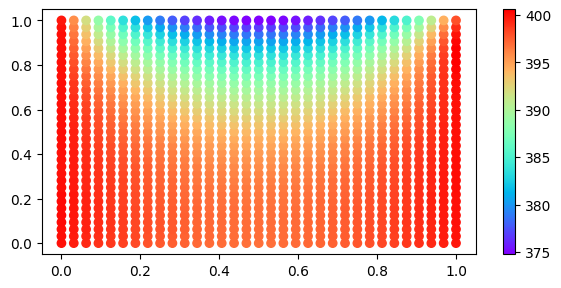

Text(0, 0.5, 'y')

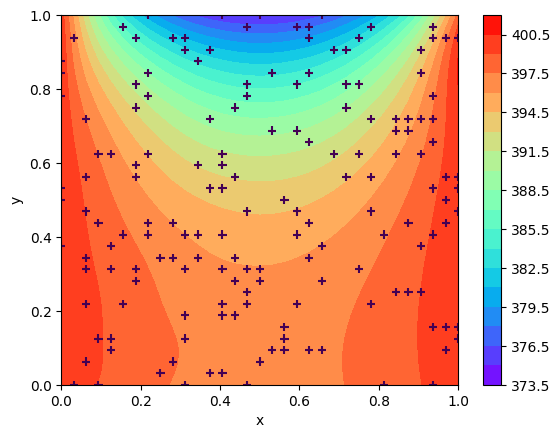

In [9]:
# print(u_pred.shape)

output_u = (u_pred*(T_max-T_min))+T_min

# output_u = (((u_pred+1)/2)*(T_max-T_min))+T_min

print(output_u)

x = x_test.detach().cpu().numpy()
x0 = x[:,0]
y0 = x[:,1]

# print(x0.shape)
# print(output_u.shape)

x_train_nu0 = x_train_nu.cpu().detach().numpy()
T_train_nu0 = T_train_nu.cpu().detach().numpy()
# print(x_train_nu[:,0].reshape(-1,1))
# print(T_train_nu0.shape)


plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.scatter(y0, x0, c = output_u , cmap = 'rainbow')
plt.colorbar()
plt.show()

x1 = x0.reshape(33,33)
y1 = y0.reshape(33,33)

plt.subplot(1, 1, 1)
cp = plt.contourf(y1, x1, output_u,20,cmap="rainbow")
plt.colorbar(cp) # Add a colorbar to a plot
plt.scatter(x_train_nu[:,0].cpu().reshape(-1,1), x_train_nu[:,1].cpu().reshape(-1,1), c = T_train_nu0*0, marker='+')
plt.xlabel('x')
plt.ylabel('y')

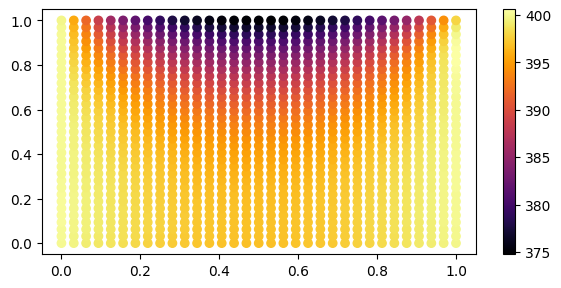

Text(0, 0.5, 'y')

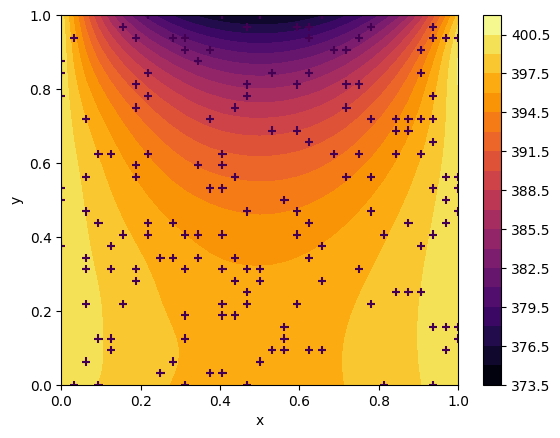

In [18]:
plt.figure(figsize=(7,7))
plt.subplot(2, 1, 1)
plt.scatter(y0, x0, c = output_u , cmap = 'inferno')
plt.colorbar()
plt.show()

x1 = x0.reshape(33,33)
y1 = y0.reshape(33,33)

plt.subplot(1, 1, 1)
cp = plt.contourf(y1, x1, output_u,20,cmap="inferno")
plt.colorbar(cp) # Add a colorbar to a plot
plt.scatter(x_train_nu[:,0].cpu().reshape(-1,1), x_train_nu[:,1].cpu().reshape(-1,1), c = T_train_nu0*0, marker='+')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

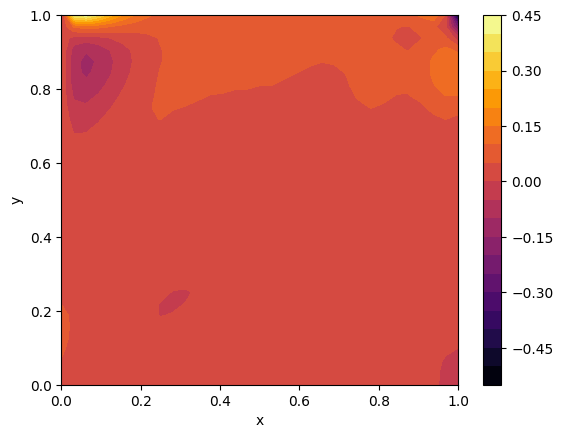

In [17]:
T_ot = data['Temperature'].to_numpy().reshape(33,33)
T_ot = T_ot.T
# cp = plt.contourf(y1, x1, T_ot.T,20,cmap="rainbow")

cp = plt.contourf(y1, x1, (output_u-T_ot)/T_ot*100,20,cmap="inferno")
plt.colorbar(cp) # Add a colorbar to a plot
# plt.scatter(x_train_nu[:,0].cpu().reshape(-1,1), x_train_nu[:,1].cpu().reshape(-1,1), c = T_train_nu0*0, marker='+')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
# save model
torch.save(PINN.state_dict(),'/content/gdrive/MyDrive/project_one/2D_plate_Heattransfer/PINN_model4.pt')